In [2]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets  # interactive display
from scipy.stats import poisson

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("../JC.mplstyle")


In [87]:
def plot_policy_and_value(policy, values, policy_title='Policy', value_title='Value Function'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Policy plot
    im1 = ax1.imshow(policy, origin='lower', cmap='coolwarm', extent=(0, 20, 0, 20))
    ax1.set_title(policy_title)
    ax1.set_xlabel("Cars at location 1")
    ax1.set_ylabel("Cars at location 2")

    # Colorbar for policy plot
    cbar1 = ax1.figure.colorbar(im1, ax=ax1)
    cbar1.ax.set_ylabel("Actions", rotation=-90, va="bottom")

    # Value function plot
    im2 = ax2.imshow(values, origin='lower', cmap='coolwarm', extent=(0, 20, 0, 20))
    ax2.set_title(value_title)
    ax2.set_xlabel("Cars at location 1")
    ax2.set_ylabel("Cars at location 2")

    # Colorbar for value function plot
    cbar2 = ax2.figure.colorbar(im2, ax=ax2)
    cbar2.ax.set_ylabel("Value", rotation=-90, va="bottom")

    plt.show()

In [88]:
class GridWorld:
    def __init__(self, shape=[4, 4]):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_actions = 4
        self.grid = np.zeros(shape)

        # Define terminal states
        self.grid[0, 0] = 1
        self.grid[shape[0]-1, shape[1]-1] = 1

        # Define rewards for each state and action. 
        # For the gridworld problem, reward is independent of action.
        self.rewards = np.ones_like(self.grid) * -1
        self.rewards[0, 0] = 0
        self.rewards[shape[0]-1, shape[1]-1] = 0

    def get_state(self, x, y):
        return np.ravel_multi_index((x, y), self.shape)

    def get_position(self, state):
        return np.unravel_index(state, self.shape)

    def is_terminal(self, state):
        x, y = self.get_position(state)
        return self.grid[x, y] == 1

    def get_reward(self, state):
        x, y = self.get_position(state)
        return self.rewards[x, y]

    def step(self, state, action):
        x, y = self.get_position(state)
        current_state = self.get_state(x, y)
        if ~self.is_terminal(current_state):
            if action == 0: # up
                x = max(x-1, 0)
            elif action == 1: # down
                x = min(x+1, self.shape[0]-1)
            elif action == 2: # left
                y = max(y-1, 0)
            elif action == 3: # right
                y = min(y+1, self.shape[1]-1)

        next_state = self.get_state(x, y)
        reward = self.get_reward(current_state)
        done = self.is_terminal(next_state)

        return next_state, reward, done     

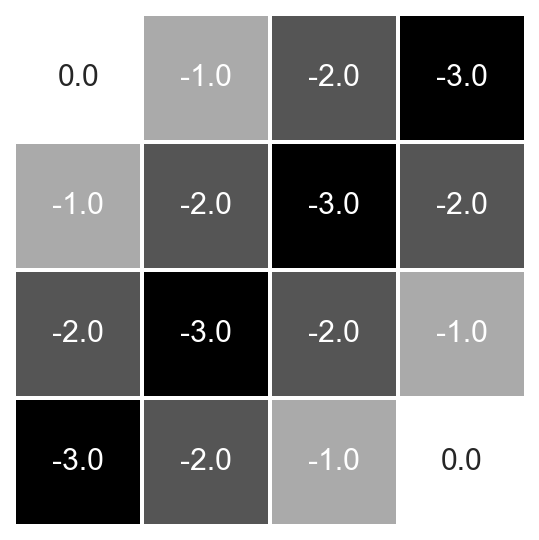

In [89]:
# Policy iteration for state values
gridworld = GridWorld()
values = np.zeros(gridworld.n_states)
policy = np.ones((gridworld.n_states, gridworld.n_actions))/4
while True:
    # Policy evaluation
    while True:
        delta = 0
        for s in range(gridworld.n_states):
            v = values[s]
            state_value = 0
            for a in range(gridworld.n_actions):
                next_s, reward, done = gridworld.step(s, a)
                state_value += policy[s][a] * (reward + values[next_s])
            values[s] = state_value
            delta = max(delta, abs(v - values[s]))
        if delta < 1e-4:
            break

    # Policy improvement
    policy_stable = True
    for s in range(gridworld.n_states):
        old_action = np.argmax(policy[s])
        state_values = []
        for a in range(gridworld.n_actions):
            next_s, reward, done = gridworld.step(s, a)
            state_values.append(reward + values[next_s])
        new_action = np.argmax(state_values)
        if old_action != new_action:
            policy_stable = False
        policy[s] = np.eye(gridworld.n_actions)[new_action]
    
    if policy_stable:
        break


sns.heatmap(values.reshape(gridworld.shape), annot=True, cmap="gray", fmt=".1f", linewidths=2,
            cbar=False, square=True, xticklabels=False, yticklabels=False)
plt.show()

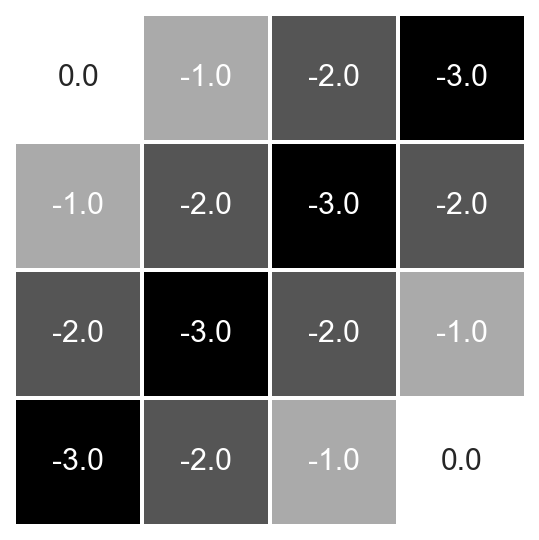

In [90]:
# Policy iteration for action values
gridworld = GridWorld()
action_values = np.zeros((gridworld.n_states, gridworld.n_actions))
policy = np.ones((gridworld.n_states, gridworld.n_actions))/4
while True:
    # Policy evaluation
    while True:
        delta = 0
        for s in range(gridworld.n_states):
            for a in range(gridworld.n_actions):
                q_old = action_values[s][a]
                next_s, reward, done = gridworld.step(s, a)
                q_new = reward
                for next_action in range(gridworld.n_actions):
                    q_new += policy[next_s][next_action] * action_values[next_s][next_action]
                delta = max(delta, abs(q_new - q_old))
                action_values[s][a] = q_new
        if delta < 1e-4:
            break

    # Policy improvement
    policy_stable = True
    old_action = np.argmax(policy, axis=1)
    new_action = np.argmax(action_values, axis=1)
    if not np.all(old_action == new_action):
        policy_stable = False
    policy = np.zeros((gridworld.n_states, gridworld.n_actions))
    policy[np.arange(gridworld.n_states), new_action] = 1    
    if policy_stable:
        break

values = np.sum(action_values * policy, axis=1)
sns.heatmap(values.reshape(gridworld.shape), annot=True, cmap="gray", fmt=".1f", linewidths=2,
            cbar=False, square=True, xticklabels=False, yticklabels=False)
plt.show()

In [92]:
class JacksCarRental:
    def __init__(self, max_cars=20, max_move=5, request_rate=(3, 4), return_rate=(3, 2),
                 rental_income=10, move_car_cost=2, gamma=0.9):
        self.max_cars = max_cars
        self.max_move = max_move
        self.request_rate = request_rate
        self.return_rate = return_rate
        self.rental_income = rental_income
        self.move_car_cost = move_car_cost
        self.gamma = gamma
        self.compute_rental_and_return_p()
        self.transition_prob()
        
    # Pre-compute the probability of rental and return
    def compute_rental_and_return_p(self):
        # probability mass function: Pr(X = n)
        self.rental_pmf_loc1 = np.array([poisson.pmf(n, self.request_rate[0]) for n in range(self.max_cars + 1)])
        self.rental_pmf_loc2 = np.array([poisson.pmf(n, self.request_rate[1]) for n in range(self.max_cars + 1)])
        self.return_pmf_loc1 = np.array([poisson.pmf(n, self.return_rate[0]) for n in range(self.max_cars + 1)])
        self.return_pmf_loc2 = np.array([poisson.pmf(n, self.return_rate[1]) for n in range(self.max_cars + 1)])
        # survival function: P[n] = Pr(X > n-1) = Pr(X >= n)
        self.rental_sf_loc1 = np.array([poisson.sf(n-1, self.request_rate[0]) for n in range(self.max_cars + 1)])
        self.rental_sf_loc2 = np.array([poisson.sf(n-1, self.request_rate[1]) for n in range(self.max_cars + 1)])
        self.return_sf_loc1 = np.array([poisson.sf(n-1, self.return_rate[0]) for n in range(self.max_cars + 1)])
        self.return_sf_loc2 = np.array([poisson.sf(n-1, self.return_rate[1]) for n in range(self.max_cars + 1)])

    # Compute the rental reward
    # Since the rental reward is only based on the number of cars after moving, we can pre-compute the rental reward
    def transition_prob(self):
        self.state_transition_prob = np.zeros((self.max_cars + 1, self.max_cars + 1, self.max_cars + 1, self.max_cars + 1))
        self.state_transition_reward = np.zeros((self.max_cars + 1, self.max_cars + 1, self.max_cars + 1, self.max_cars + 1))
        
        for s in [(car_loc1, car_loc2) for car_loc1 in range(self.max_cars+1) for car_loc2 in range(self.max_cars+1)]:
            cars_loc1, cars_loc2 = s
            for rent1 in range(cars_loc1 + 1):
                for rent2 in range(cars_loc2 + 1):
                    reward_rent = self.rental_income * (rent1 + rent2)
                    if rent1 < cars_loc1:
                        prob_rent1 = self.rental_pmf_loc1[rent1]
                    else:
                        prob_rent1 = self.rental_sf_loc1[cars_loc1]
                    if rent2 < cars_loc2:
                        prob_rent2 = self.rental_pmf_loc2[rent2]
                    else:
                        prob_rent2 = self.rental_sf_loc2[cars_loc2]
                    prob_rent = prob_rent1 * prob_rent2

                    remaining_cars_loc1 = cars_loc1 - rent1
                    remaining_cars_loc2 = cars_loc2 - rent2

                    for return1 in range(self.max_cars - remaining_cars_loc1 + 1):
                        for return2 in range(self.max_cars - remaining_cars_loc2 + 1):
                            if return1 < self.max_cars - remaining_cars_loc1:
                                prob_return1 = self.return_pmf_loc1[return1]
                            else:
                                prob_return1 = self.return_sf_loc1[self.max_cars - remaining_cars_loc1]
                            if return2 < self.max_cars - remaining_cars_loc2:
                                prob_return2 = self.return_pmf_loc2[return2]
                            else:
                                prob_return2 = self.return_sf_loc2[self.max_cars - remaining_cars_loc2]
                            prob_return = prob_return1 * prob_return2

                            new_cars_loc1 = remaining_cars_loc1 + return1
                            new_cars_loc2 = remaining_cars_loc2 + return2
                            new_s = (new_cars_loc1, new_cars_loc2)
                            
                            prob = prob_rent * prob_return
                            
                            self.state_transition_prob[cars_loc1, cars_loc2, new_cars_loc1, new_cars_loc2] += prob
                            self.state_transition_reward[cars_loc1, cars_loc2, new_cars_loc1, new_cars_loc2] += reward_rent * prob
                                  
    def value_update(self, s, a, v):
        cars_loc1, cars_loc2 = s

        cars_loc1 -= a
        cars_loc2 += a
        cars_loc1 = min(cars_loc1, self.max_cars)
        cars_loc2 = min(cars_loc2, self.max_cars)

        move_cost = self.move_car_cost * abs(a)
        return np.sum(self.state_transition_reward[cars_loc1, cars_loc2, : ,:]  + self.gamma * v * self.state_transition_prob[cars_loc1, cars_loc2, : ,:]) - move_cost

env = JacksCarRental()

C:\Users\yuang\AppData\Local\Temp\ipykernel_27608\2556278794.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  policy = np.zeros((env.max_cars+1, env.max_cars+1), dtype=np.int)


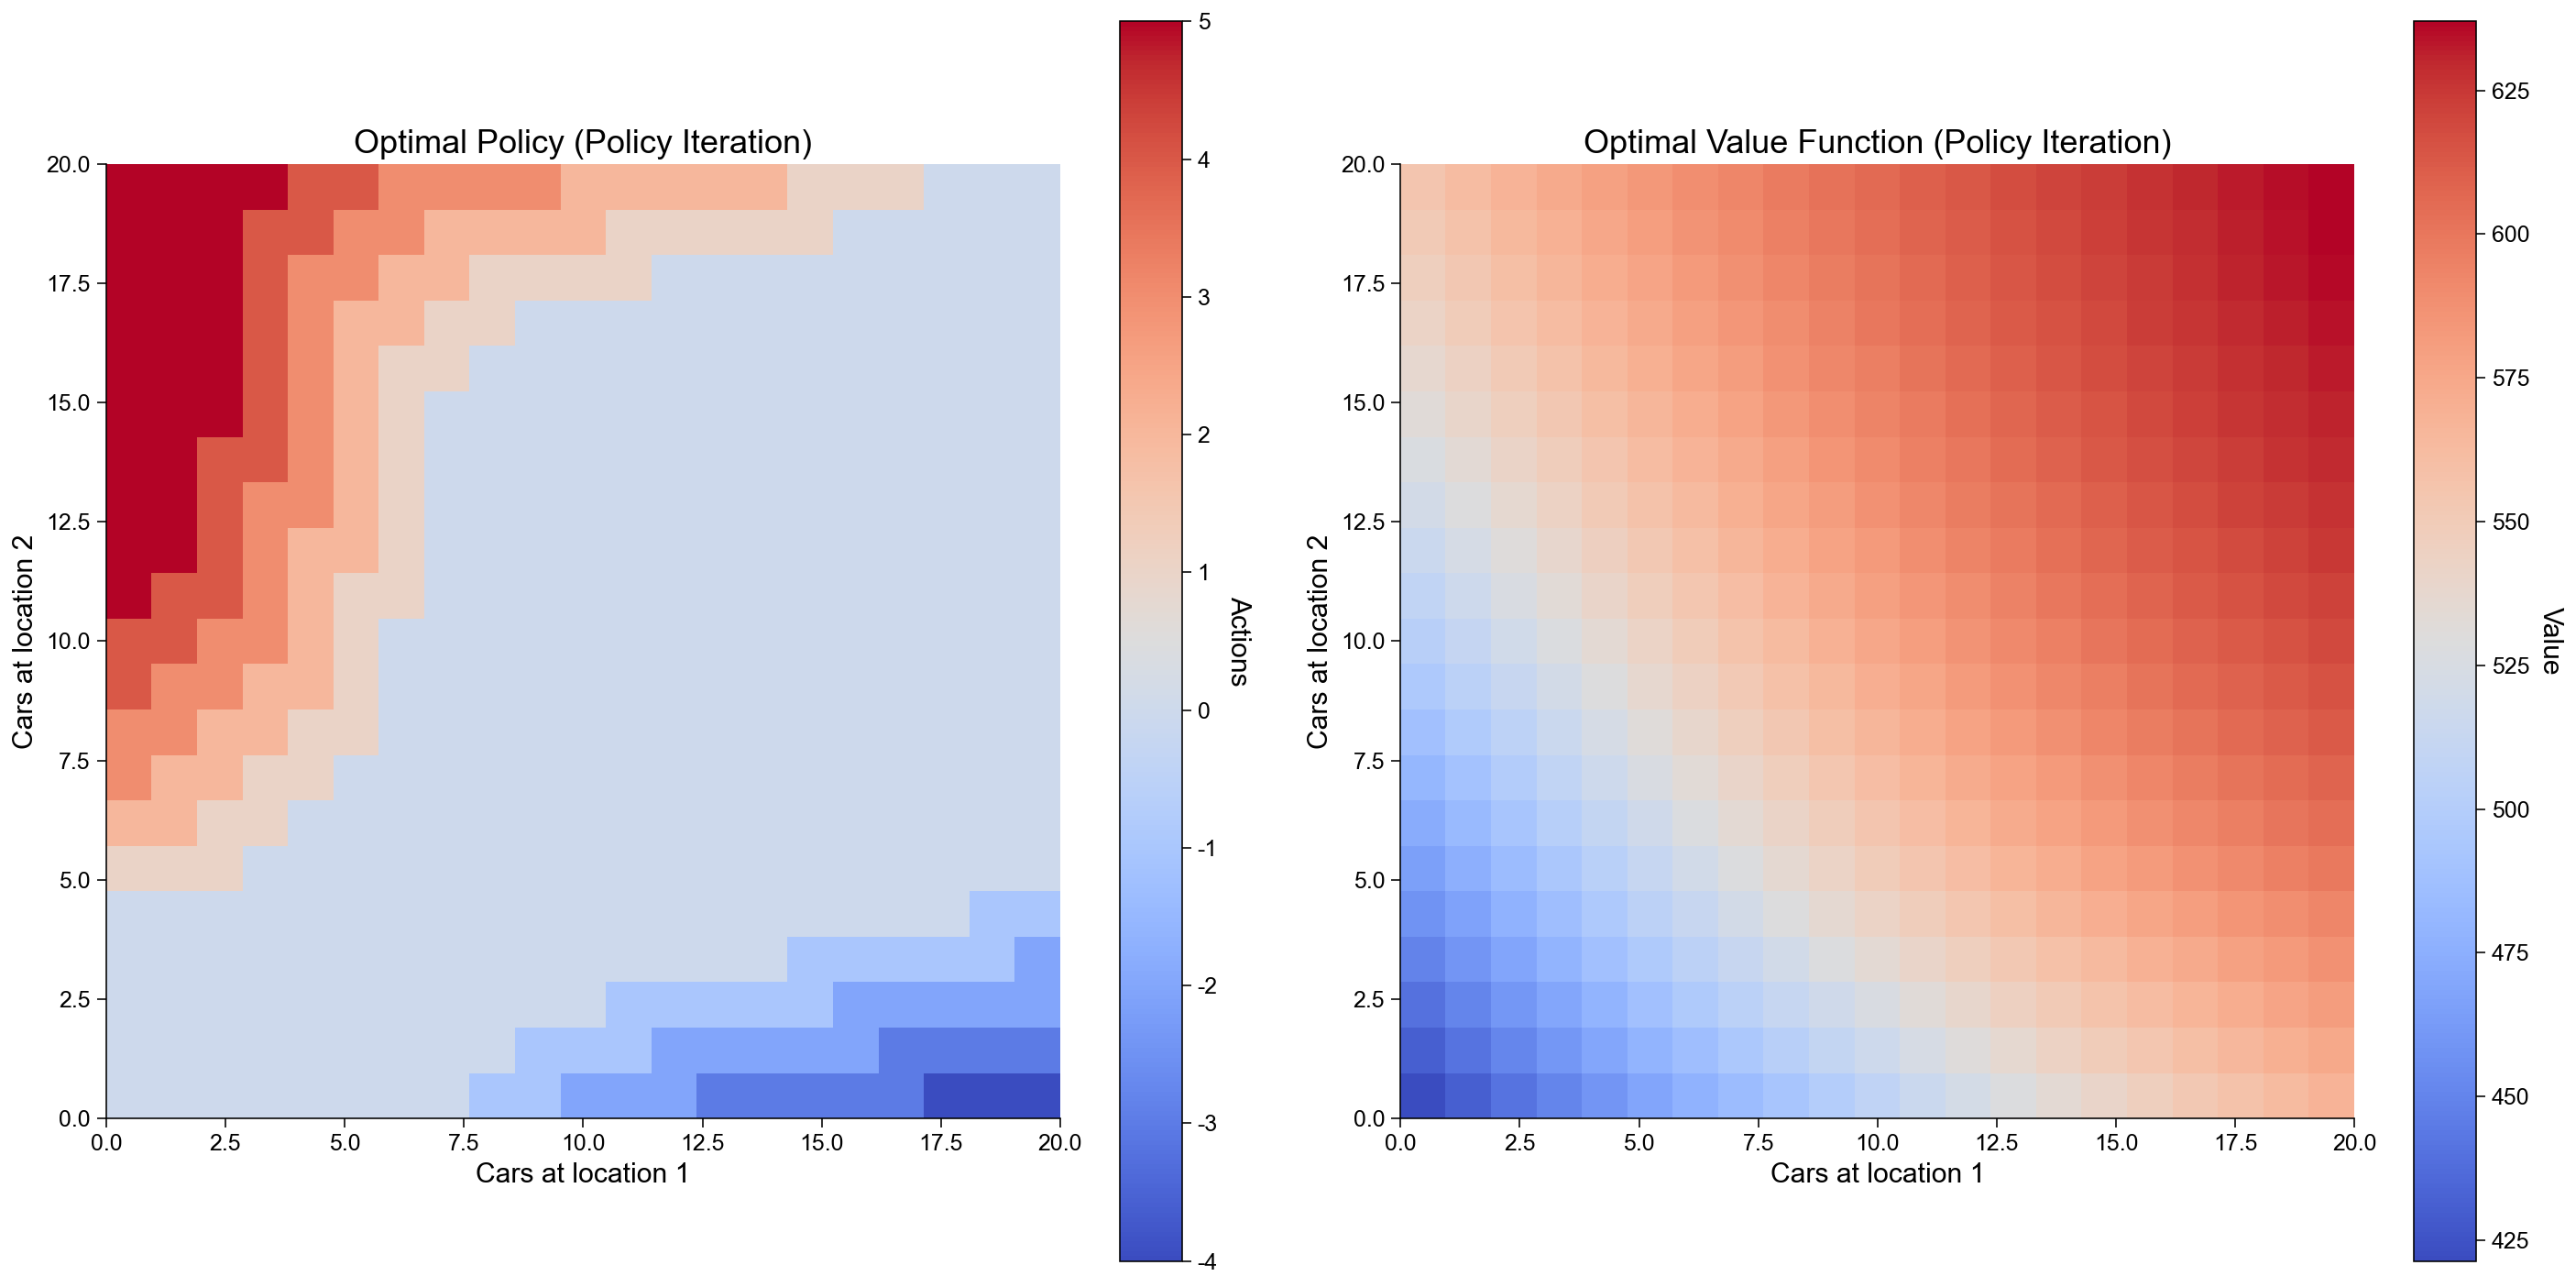

In [98]:
values = np.zeros((env.max_cars+1, env.max_cars+1))
policy = np.zeros((env.max_cars+1, env.max_cars+1), dtype=np.int)
while True:
    # Policy evaluation
    while True:
        delta = 0
        for s in [(car_loc1, car_loc2) for car_loc1 in range(env.max_cars+1) for car_loc2 in range(env.max_cars+1)]:
            v = values[s]
            a = policy[s]
            values[s] = env.value_update(s, a, values)
            delta = max(delta, abs(v - values[s]))
        if delta < 1e-4:
            break

    # Policy improvement
    policy_stable = True
    for s in [(car_loc1, car_loc2) for car_loc1 in range(env.max_cars+1) for car_loc2 in range(env.max_cars+1)]:
        old_action = policy[s]
        state_values = []
        actions_valid = [a for a in range(max(-s[1], -env.max_move), min(s[0], env.max_move) + 1)]
        for a in actions_valid:
            state_value = env.value_update(s, a, values)
            state_values.append(state_value)
        new_action = actions_valid[np.argmax(state_values)]
        if old_action != new_action:
            policy_stable = False
        policy[s] = new_action
    
    if policy_stable:
        break
plot_policy_and_value(policy, values, policy_title='Optimal Policy (Policy Iteration)', value_title='Optimal Value Function (Policy Iteration)')

C:\Users\yuang\AppData\Local\Temp\ipykernel_27608\1048829995.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  policy = np.zeros((env.max_cars+1, env.max_cars+1), dtype=np.int)


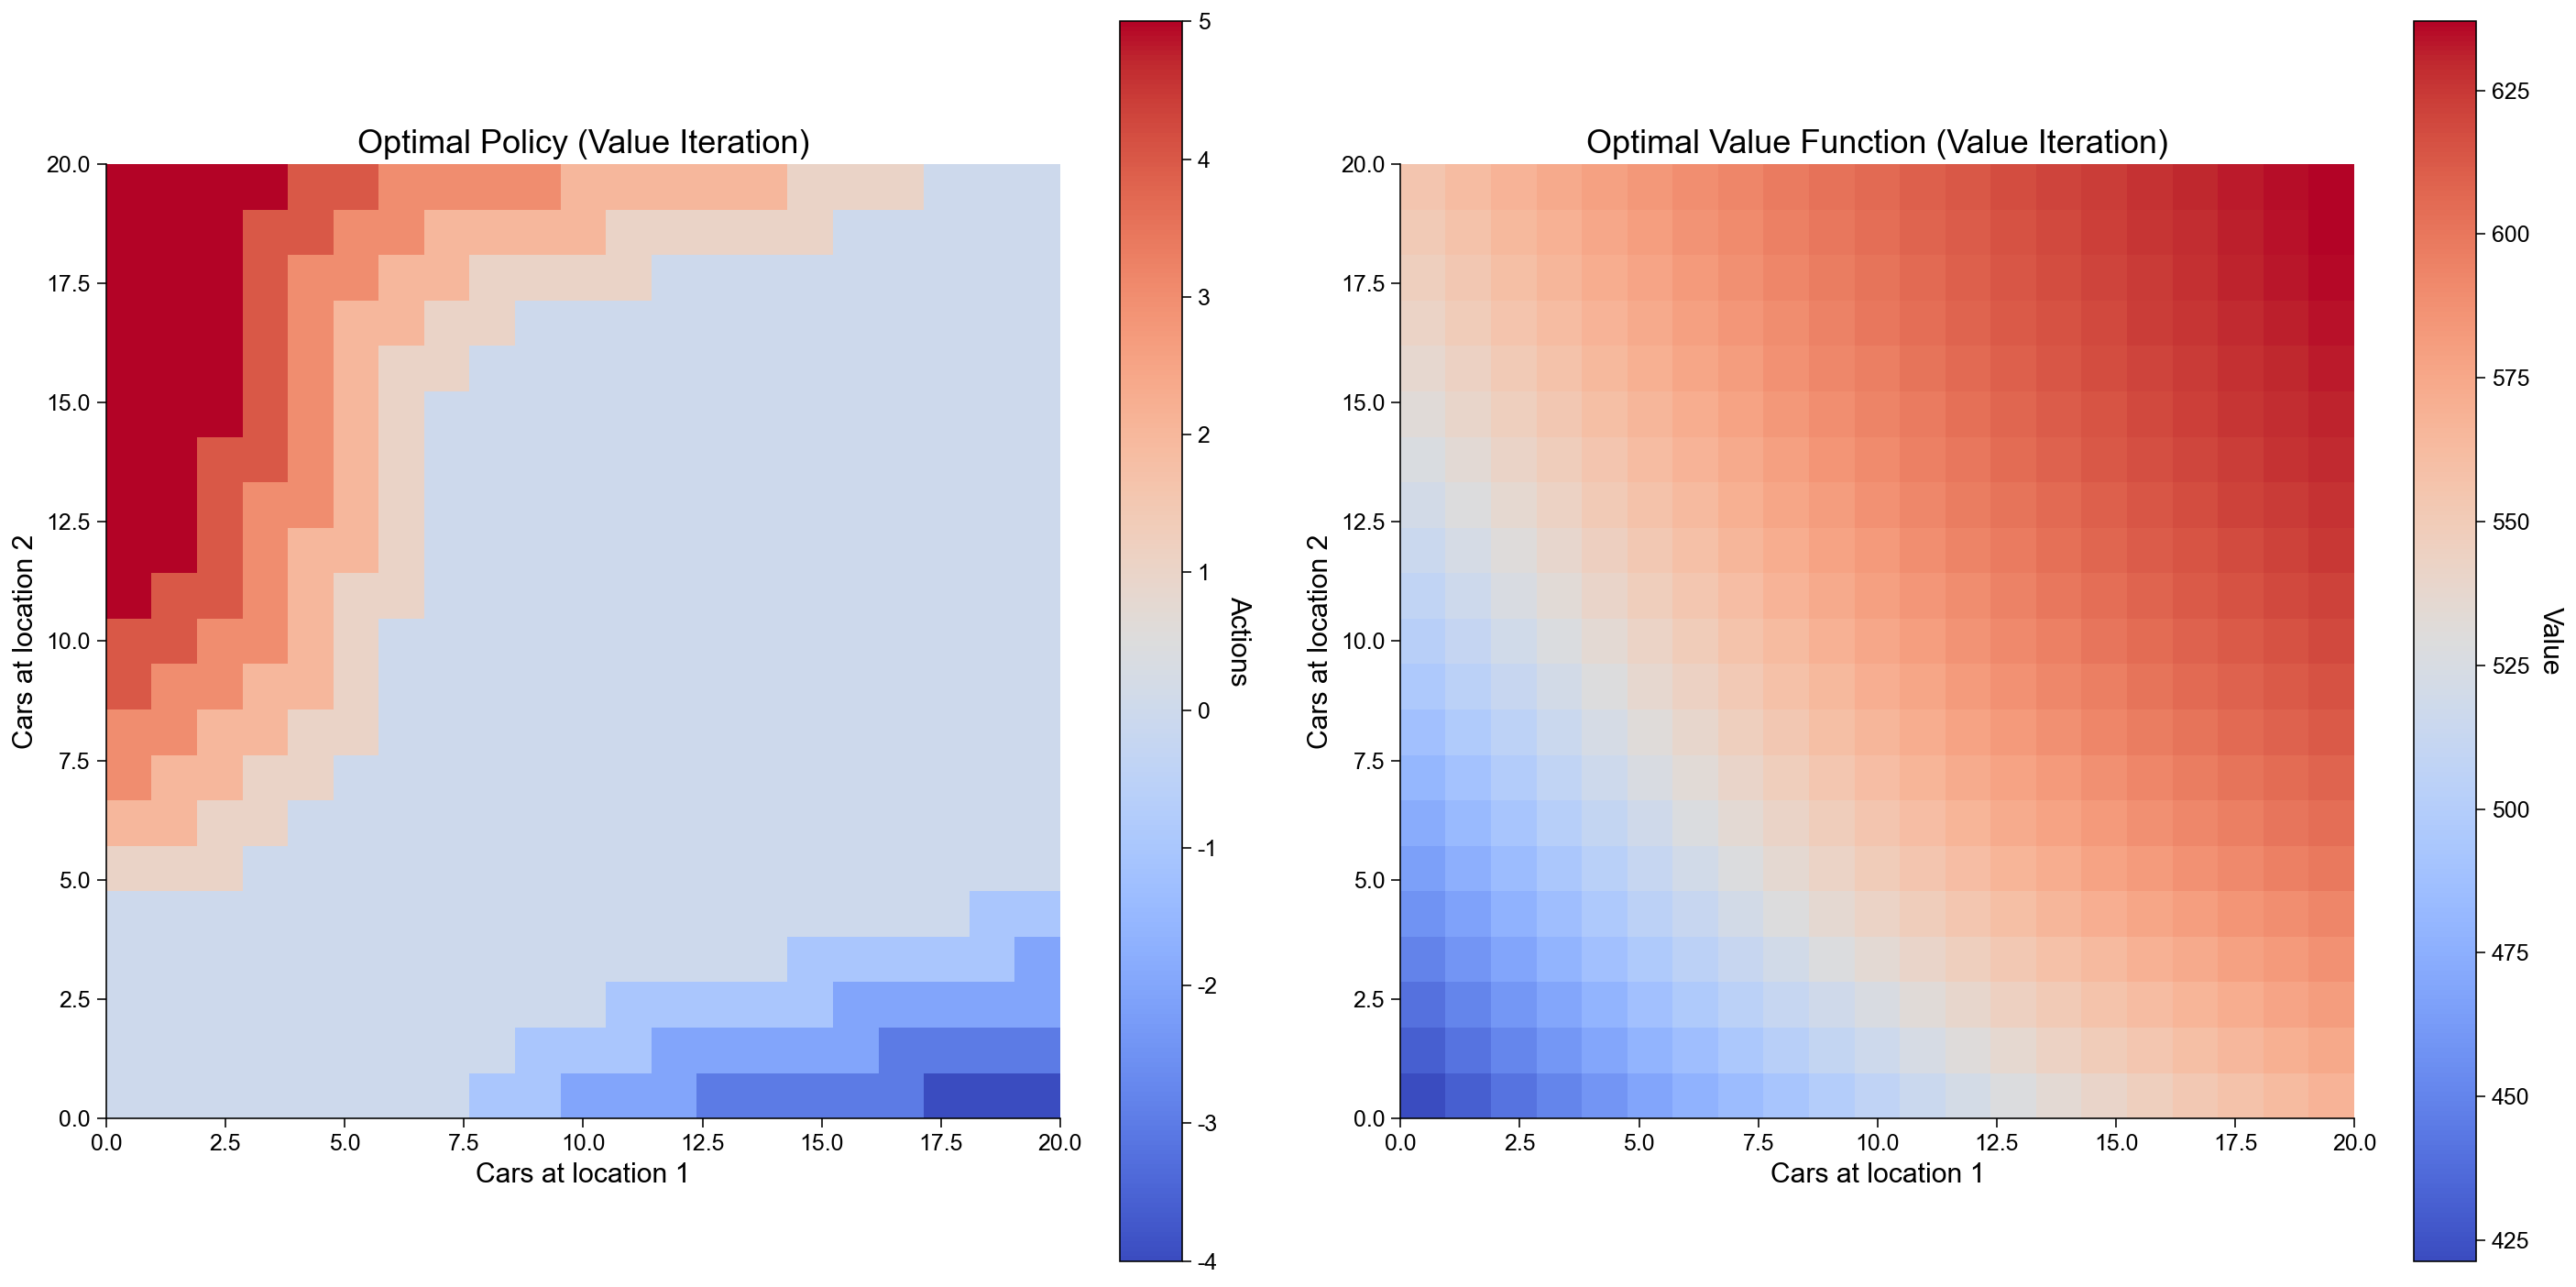

In [101]:
values = np.zeros((env.max_cars+1, env.max_cars+1))
policy = np.zeros((env.max_cars+1, env.max_cars+1), dtype=np.int)
# Value iteration
while True:
    delta = 0
    for s in [(car_loc1, car_loc2) for car_loc1 in range(env.max_cars+1) for car_loc2 in range(env.max_cars+1)]:
        v = values[s]
        state_values = []
        actions_valid = [a for a in range(max(-s[1], -env.max_move), min(s[0], env.max_move) + 1)]
        for a in actions_valid:
            state_value = env.value_update(s, a, values)
            state_values.append(state_value)
        values[s] = np.max(np.array(state_values))
        delta = max(delta, abs(v - values[s]))
    if delta < 1e-4:
        break
# Extract optimal policy from converged value function
for s in [(car_loc1, car_loc2) for car_loc1 in range(env.max_cars+1) for car_loc2 in range(env.max_cars+1)]:
    state_values = []
    actions_valid = [a for a in range(max(-s[1], -env.max_move), min(s[0], env.max_move) + 1)]
    for a in actions_valid:
        state_value = env.value_update(s, a, values)
        state_values.append(state_value)
    optimal_action = actions_valid[np.argmax(state_values)]
    policy[s] = optimal_action
plot_policy_and_value(policy, values, policy_title='Optimal Policy (Value Iteration)', value_title='Optimal Value Function (Value Iteration)')

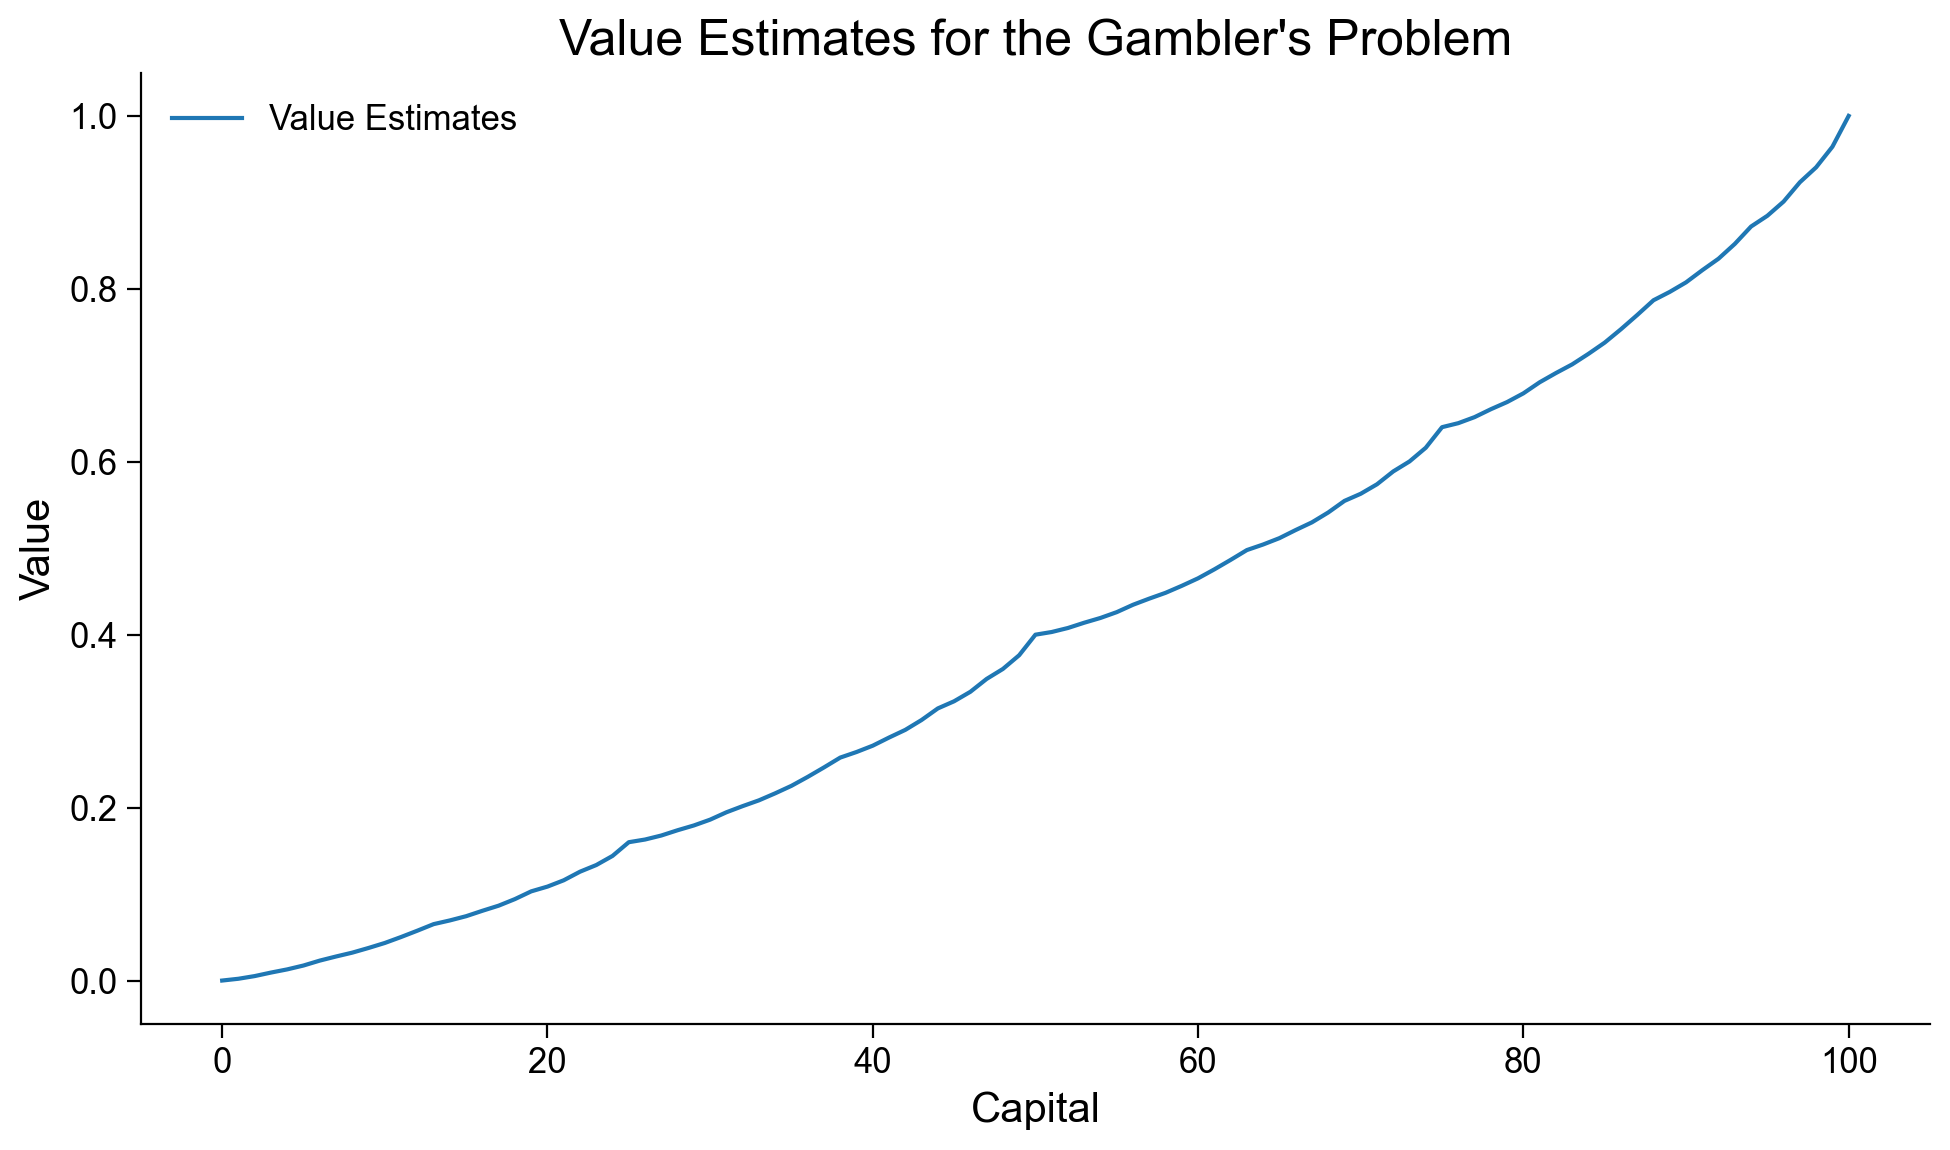

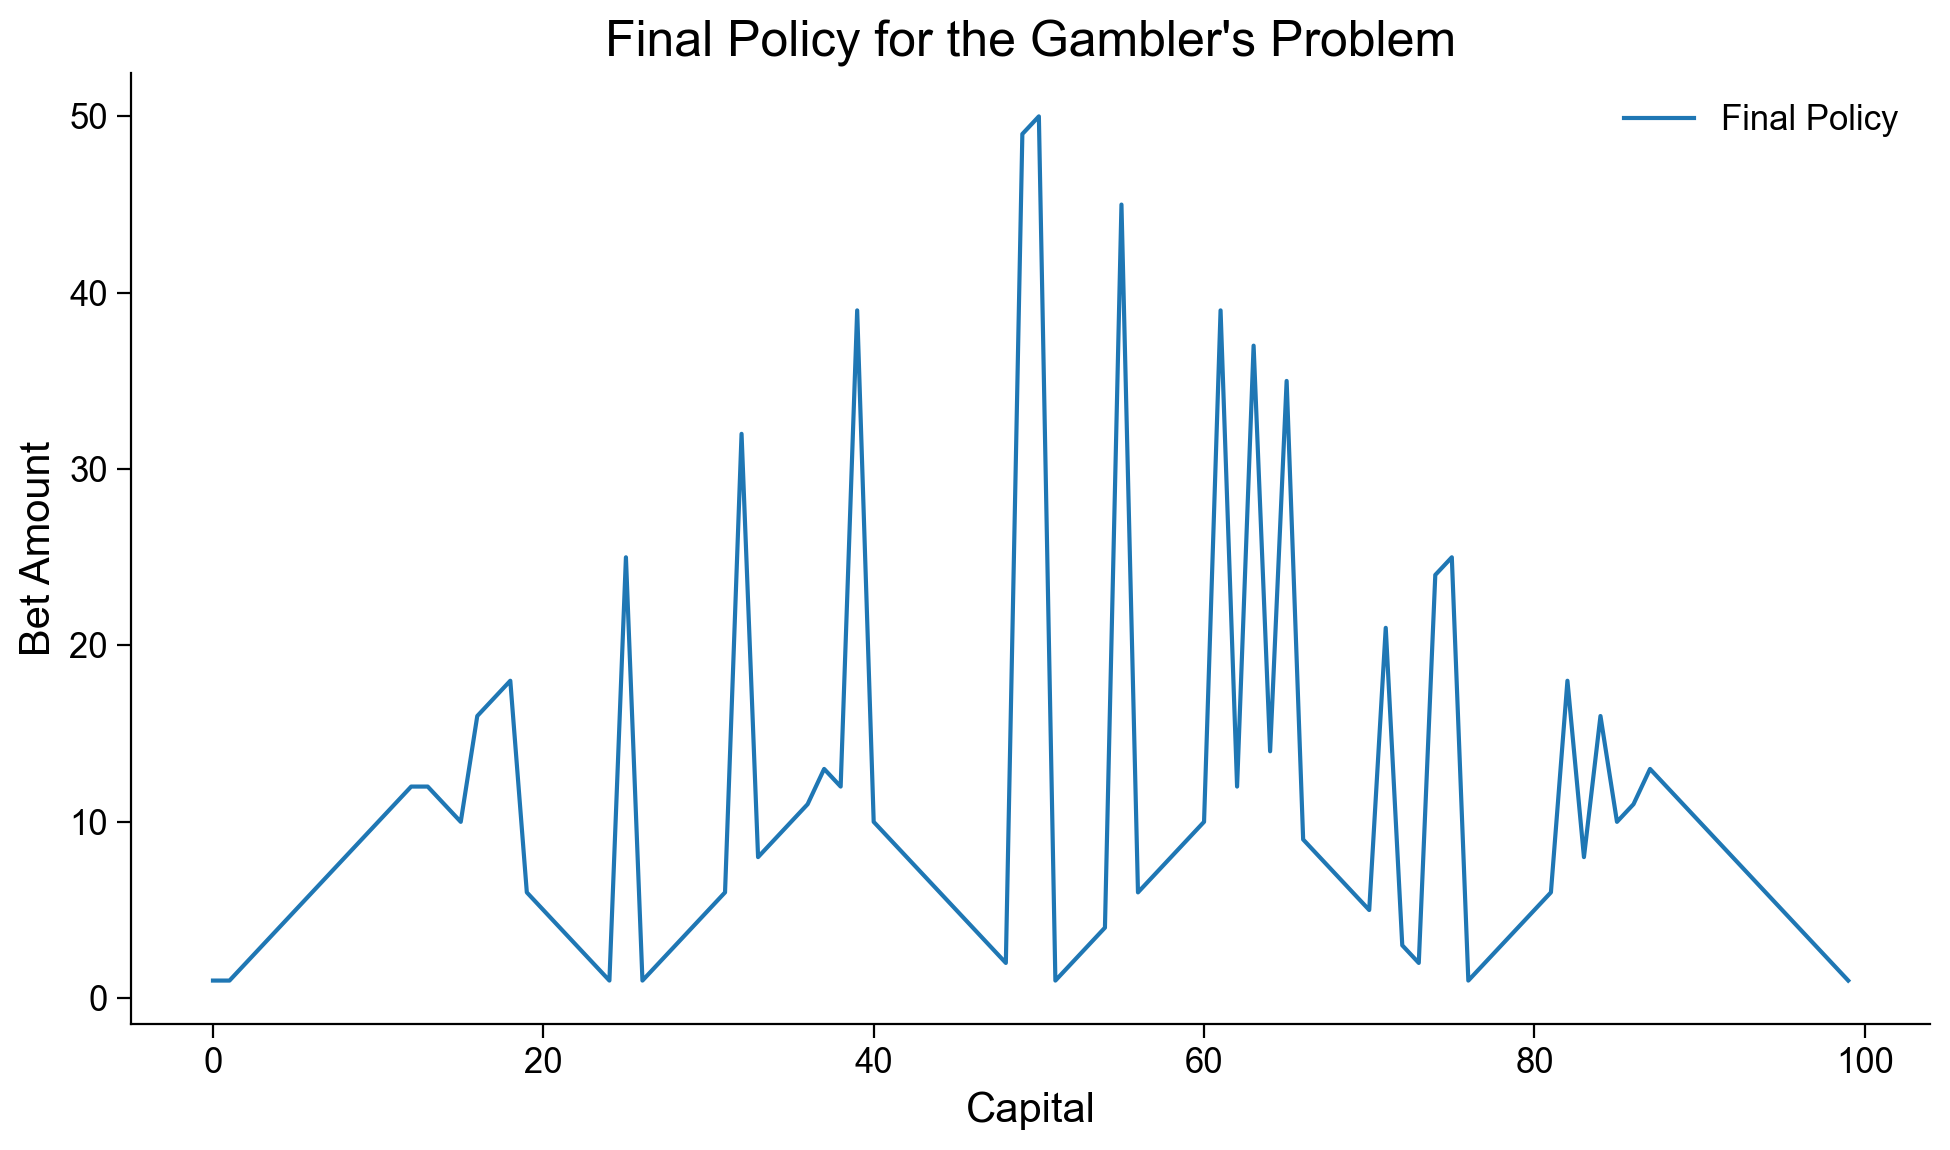

In [17]:
# Gambler's Problem
values = np.zeros(101)
values[-1] = 1
policy = np.ones(100, dtype=np.int32)

# Value iteration
while True:
    delta = 0
    for s in np.arange(1, 100):
        v = values[s]
        state_values = []
        actions_valid = np.arange(1, min(s, 100-s) + 1)
        for a in actions_valid:
            state_value = 0.4 * (0 + values[min(s + a, 100)]) + 0.6 * (0 + values[max(s - a, 0)])
            state_values.append(state_value)
        values[s] = np.max(np.array(state_values))
        delta = max(delta, abs(v - values[s]))
    if delta <= 0:
        break

    # Determine the final policy
    for s in np.arange(1, 100):
        state_values = []
        actions_valid = np.arange(1, min(s, 100-s) + 1)
        for a in actions_valid:
            state_value = 0.4 * (0 + values[min(s + a, 100)]) + 0.6 * (0 + values[max(s - a, 0)])
            state_values.append(state_value)
        optimal_action = actions_valid[np.argmax(state_values)]
        policy[s] = optimal_action

# Plot Value Estimates
plt.figure(figsize=(10, 6))
plt.plot(values, label='Value Estimates')
plt.xlabel('Capital')
plt.ylabel('Value')
plt.title("Value Estimates for the Gambler's Problem")
plt.legend()
plt.show()

# Plot Final Policy
plt.figure(figsize=(10, 6))
plt.plot(policy, label='Final Policy')
plt.xlabel('Capital')
plt.ylabel('Bet Amount')
plt.title("Final Policy for the Gambler's Problem")
plt.legend()
plt.show()